In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [23]:
from models import LeNet, LeNet_dropout, LeNet_BatchNorm
from train import train_model

In [24]:
model1 = LeNet()
model1

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Epoch 0/200 - Loss: 3.5547 - Accuracy: 0.1016
Epoch 50/200 - Loss: 1.5267 - Accuracy: 0.5234
Epoch 100/200 - Loss: 0.7655 - Accuracy: 0.7500
Epoch 150/200 - Loss: 0.5995 - Accuracy: 0.8359
Finished - Loss: 0.4122 - Accuracy: 0.8438


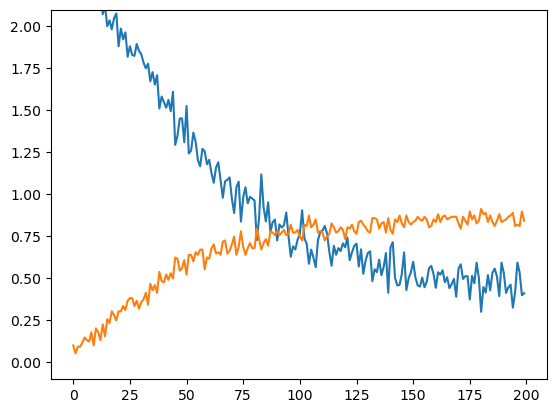

In [25]:
losses, accuracies = train_model(model1, X_train, Y_train)
plt.ylim(-0.1, 2.1)
plt.plot(losses)
plt.plot(accuracies);

In [26]:
Y_test_preds = torch.argmax(model1(torch.tensor(X_test.reshape((10000,1, 28,28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.8703

In [27]:
model2 = LeNet_dropout()
model2

LeNet_dropout(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Epoch 0/200 - Loss: 6.6495 - Accuracy: 0.0938
Epoch 50/200 - Loss: 1.7485 - Accuracy: 0.4609
Epoch 100/200 - Loss: 1.3660 - Accuracy: 0.5312
Epoch 150/200 - Loss: 1.0697 - Accuracy: 0.6172
Finished - Loss: 0.8960 - Accuracy: 0.6406


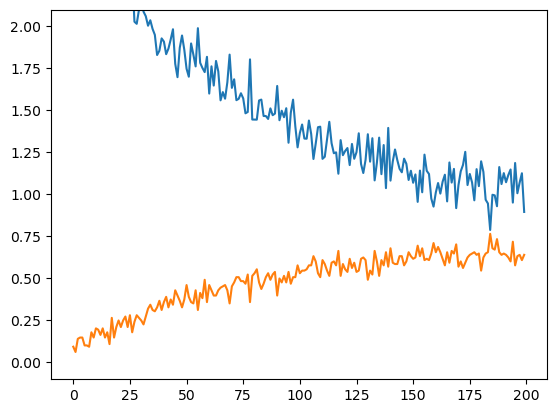

In [28]:
losses, accuracies = train_model(model2, X_train, Y_train)
plt.ylim(-0.1, 2.1)
plt.plot(losses)
plt.plot(accuracies)

In [29]:
Y_test_preds = torch.argmax(model2(torch.tensor(X_test.reshape((10000,1, 28,28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.671

In [30]:
model3 = LeNet_BatchNorm()
model3

LeNet_BatchNorm(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Epoch 0/500 - Loss: 1.8538 - Accuracy: 0.4844
Epoch 50/500 - Loss: 1.7354 - Accuracy: 0.6406
Epoch 100/500 - Loss: 1.6839 - Accuracy: 0.6016
Epoch 150/500 - Loss: 1.4445 - Accuracy: 0.7188
Epoch 200/500 - Loss: 1.5951 - Accuracy: 0.6719
Epoch 250/500 - Loss: 1.4055 - Accuracy: 0.7109
Epoch 300/500 - Loss: 1.2978 - Accuracy: 0.8281
Epoch 350/500 - Loss: 1.2572 - Accuracy: 0.8125
Epoch 400/500 - Loss: 1.2452 - Accuracy: 0.7891
Epoch 450/500 - Loss: 1.1634 - Accuracy: 0.8047
Finished - Loss: 1.1593 - Accuracy: 0.8203


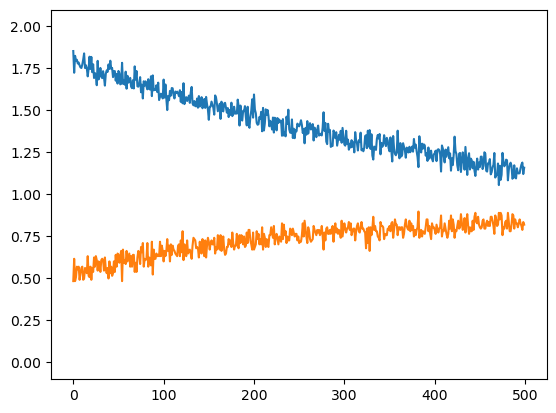

In [33]:
losses, accuracies = train_model(model3, X_train, Y_train, 500)
plt.ylim(-0.1, 2.1)
plt.plot(losses)
plt.plot(accuracies)

In [34]:
Y_test_preds = torch.argmax(model3(torch.tensor(X_test.reshape((10000,1, 28,28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.8391